# Final Project
## Group 38
### House of Representatives model


This notebook will open the parsed data and model past elections in order to predict the 2020 one.

The goal is to see if the demographics of a congressional district can be combined with polls to accurately predict the winner.

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

%matplotlib inline

In [63]:
data_dir = "data/"
input_files = ["final_data_h.csv"]
dfs = []
for i in input_files:
    df = pd.read_csv("%s%s" % (data_dir, i))
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

display(df.head())
display(df.tail())
print(df.columns)
print(df.shape)


year state  district     dem     rep     tot  incumbent prevparty  \
0  2012    AK         1   82927  185296  289804          1         r   
1  2012    AL         1       0  196374  200676          1         r   
2  2012    AL         2  103092  180591  283953          1         r   
3  2012    AL         3   98141  175306  273930          1         r   
4  2012    AL         4   69706  199071  269118          1         r   

   voteage_pop  voteage_m  ...  Age,35-49  Age,50-64  Age,65 and Older  \
0       260120     135526  ...          0         -4               -11   
1       362092     175695  ...          0         -4               -11   
2       357776     173303  ...          0         -4               -11   
3       342806     167660  ...          0         -4               -11   
4       370119     180295  ...          0         -4               -11   

   Income,Less Than $50K  Income,$50-100K  Income,$100K or More  Race,White  \
0                     20               -6                   -14         -20   
1                     20               -6                   -14         -20   
2                     20               -6                   -14         -20   
3                     20               -6                   -14         -20   
4                     20               -6                   -14         -20   

   Race,Non-White  Education,HS or less  Education,4yrDegree  
0              53                     3                    1  
1              76                     3                    0  
2              77                     3                    0  
3              77                     3                    1  
4              64                     3                    1  

[5 rows x 39 columns]

year state  district     dem     rep     tot  incumbent prevparty  \
2175  2020    WI         8  149558  268173  417731          1         r   
2176  2020    WV         1   81177  180488  261665          1         r   
2177  2020    WV         2  100799  172195  272994          1         r   
2178  2020    WV         3   64927  161585  226512          1         r   
2179  2020    WY         1   66576  185732  270367          1         r   

      voteage_pop  voteage_m  ...  Age,35-49  Age,50-64  Age,65 and Older  \
2175       560199     277228  ...          9        -11                12   
2176       482965     239085  ...          9        -11                12   
2177       485281     236771  ...          9        -11                12   
2178       452043     220564  ...          9        -11                12   
2179       434852     220281  ...          9        -11                12   

      Income,Less Than $50K  Income,$50-100K  Income,$100K or More  \
2175                     19               -7                    12   
2176                     19               -7                    12   
2177                     19               -7                    12   
2178                     19               -7                    12   
2179                     19               -7                    12   

      Race,White  Race,Non-White  Education,HS or less  Education,4yrDegree  
2175         -10              35                    -3                    0  
2176         -10              35                    -3                    0  
2177         -10              35                    -3                    0  
2178         -10              35                    -3                    0  
2179         -10              35                    -3                    0  

[5 rows x 39 columns]

Index(['year', 'state', 'district', 'dem', 'rep', 'tot', 'incumbent',
       'prevparty', 'voteage_pop', 'voteage_m', 'voteage_f', 'race_pop',
       'race_white', 'race_nonwhite', 'ed_pop', 'ed_4y', 'ed_no4y', 'age_pop',
       'age_18_34', 'age_35_49', 'age_50_64', 'age_65_plus', 'inc_pop',
       'inc_lt_50', 'inc_50_100', 'inc_100_plus', 'Gender,Male',
       'Gender,Female', 'Age,18-34', 'Age,35-49', 'Age,50-64',
       'Age,65 and Older', 'Income,Less Than $50K', 'Income,$50-100K',
       'Income,$100K or More', 'Race,White', 'Race,Non-White',
       'Education,HS or less', 'Education,4yrDegree'],
      dtype='object')
(2180, 39)


### Cleanup

Take the raw data, split into train and test, and fixup some columns.

In [64]:
# discard rows which do not have meaningful voting numbers
df = df[df['tot'] > 1]
df = df[df['prevparty'] != '']
print(df.shape)

# before splitting, add some columns based on others
df['demrepdiff'] = (df.dem - df.rep) / df.tot * 100
df['dem_win'] = (df['demrepdiff'] / df['demrepdiff'].abs() + 1) / 2
df['prevparty_d'] = (df.prevparty == 'd').astype(int)

# other desired columns
for c in ['voteage_m', 'voteage_f']:
    df[c + '_pct'] = df[c] / df.voteage_pop * 100
for c in ['race_white', 'race_nonwhite']:
    df[c + '_pct'] = df[c] / df.race_pop * 100
for c in ['ed_no4y', 'ed_4y']:
    df[c + '_pct'] = df[c] / df.ed_pop * 100
# for percentages, ignore under 18 age population
df['age_pop_18'] = df['age_18_34'] + df['age_35_49'] + df['age_50_64'] + df['age_65_plus']
for c in ['age_18_34', 'age_35_49', 'age_50_64', 'age_65_plus']:
    df[c + '_pct'] = df[c] / df.age_pop_18 * 100
for c in ['inc_lt_50', 'inc_50_100', 'inc_100_plus']:
    df[c + '_pct'] = df[c] / df.inc_pop * 100

arr_pcts = ['voteage_m', 'voteage_f',
            'age_18_34', 'age_35_49', 'age_50_64', 'age_65_plus',
            'inc_lt_50', 'inc_50_100', 'inc_100_plus',
            'race_white', 'race_nonwhite',
            'ed_no4y', 'ed_4y']
arr_prefs = ['Gender,Male',
             'Gender,Female', 'Age,18-34', 'Age,35-49', 'Age,50-64',
             'Age,65 and Older', 'Income,Less Than $50K', 'Income,$50-100K',
             'Income,$100K or More', 'Race,White', 'Race,Non-White',
             'Education,HS or less', 'Education,4yrDegree']
for (a,b) in zip(arr_pcts, arr_prefs):
    newf = a + "_delta"
    df[newf] = round(df[a] * df[b] / 100, -1)
    newf = a + "_deltapct"
    df[newf] = round(df[a + "_pct"] * df[b] / 100, -1)

display(df.head())
print(df.columns)
#r0 = df.iloc[0].values
#for i,c in enumerate(df.columns):
#    print(f'{c}: {r0[i]}')

(2149, 39)


year state  district     dem     rep     tot  incumbent prevparty  \
0  2012    AK         1   82927  185296  289804          1         r   
1  2012    AL         1       0  196374  200676          1         r   
2  2012    AL         2  103092  180591  283953          1         r   
3  2012    AL         3   98141  175306  273930          1         r   
4  2012    AL         4   69706  199071  269118          1         r   

   voteage_pop  voteage_m  ...  inc_100_plus_delta  inc_100_plus_deltapct  \
0       260120     135526  ...            -10750.0                   -0.0   
1       362092     175695  ...             -5290.0                   -0.0   
2       357776     173303  ...             -5100.0                   -0.0   
3       342806     167660  ...             -4890.0                   -0.0   
4       370119     180295  ...             -3900.0                   -0.0   

   race_white_delta  race_white_deltapct  race_nonwhite_delta  \
0          -97310.0                -10.0             129800.0   
1          -94020.0                -10.0             169500.0   
2          -90240.0                -10.0             178940.0   
3          -97890.0                -10.0             159250.0   
4         -119790.0                -20.0              52490.0   

   race_nonwhite_deltapct  ed_no4y_delta  ed_no4y_deltapct  ed_4y_delta  \
0                    20.0        10030.0               0.0       1300.0   
1                    20.0        10850.0               0.0          0.0   
2                    30.0        10750.0               0.0          0.0   
3                    20.0        10880.0               0.0        920.0   
4                    10.0        11720.0               0.0        700.0   

   ed_4y_deltapct  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  

[5 rows x 82 columns]

Index(['year', 'state', 'district', 'dem', 'rep', 'tot', 'incumbent',
       'prevparty', 'voteage_pop', 'voteage_m', 'voteage_f', 'race_pop',
       'race_white', 'race_nonwhite', 'ed_pop', 'ed_4y', 'ed_no4y', 'age_pop',
       'age_18_34', 'age_35_49', 'age_50_64', 'age_65_plus', 'inc_pop',
       'inc_lt_50', 'inc_50_100', 'inc_100_plus', 'Gender,Male',
       'Gender,Female', 'Age,18-34', 'Age,35-49', 'Age,50-64',
       'Age,65 and Older', 'Income,Less Than $50K', 'Income,$50-100K',
       'Income,$100K or More', 'Race,White', 'Race,Non-White',
       'Education,HS or less', 'Education,4yrDegree', 'demrepdiff', 'dem_win',
       'prevparty_d', 'voteage_m_pct', 'voteage_f_pct', 'race_white_pct',
       'race_nonwhite_pct', 'ed_no4y_pct', 'ed_4y_pct', 'age_pop_18',
       'age_18_34_pct', 'age_35_49_pct', 'age_50_64_pct', 'age_65_plus_pct',
       'inc_lt_50_pct', 'inc_50_100_pct', 'inc_100_plus_pct',
       'voteage_m_delta', 'voteage_m_deltapct', 'voteage_f_delta',
       'voteage

In [67]:
# split into test and train, then into x and y
df_mod = df.drop(columns=['year', 'state', 'district', 'dem', 'rep', 'tot', 'prevparty'])
df_train = df_mod.loc[df.year != 2020]
df_test = df_mod.loc[df.year == 2020]
X_train = df_train.drop(columns=['demrepdiff', 'dem_win'])
y_train = df_train['dem_win']
X_test = df_test.drop(columns=['demrepdiff', 'dem_win'])
y_test = df_test['dem_win']

print(f"Train {X_train.shape} {y_train.shape}")
print(f"Test {X_test.shape} {y_test.shape}")


Train (1727, 73) (1727,)
Test (422, 73) (422,)


### Show attribute relationships

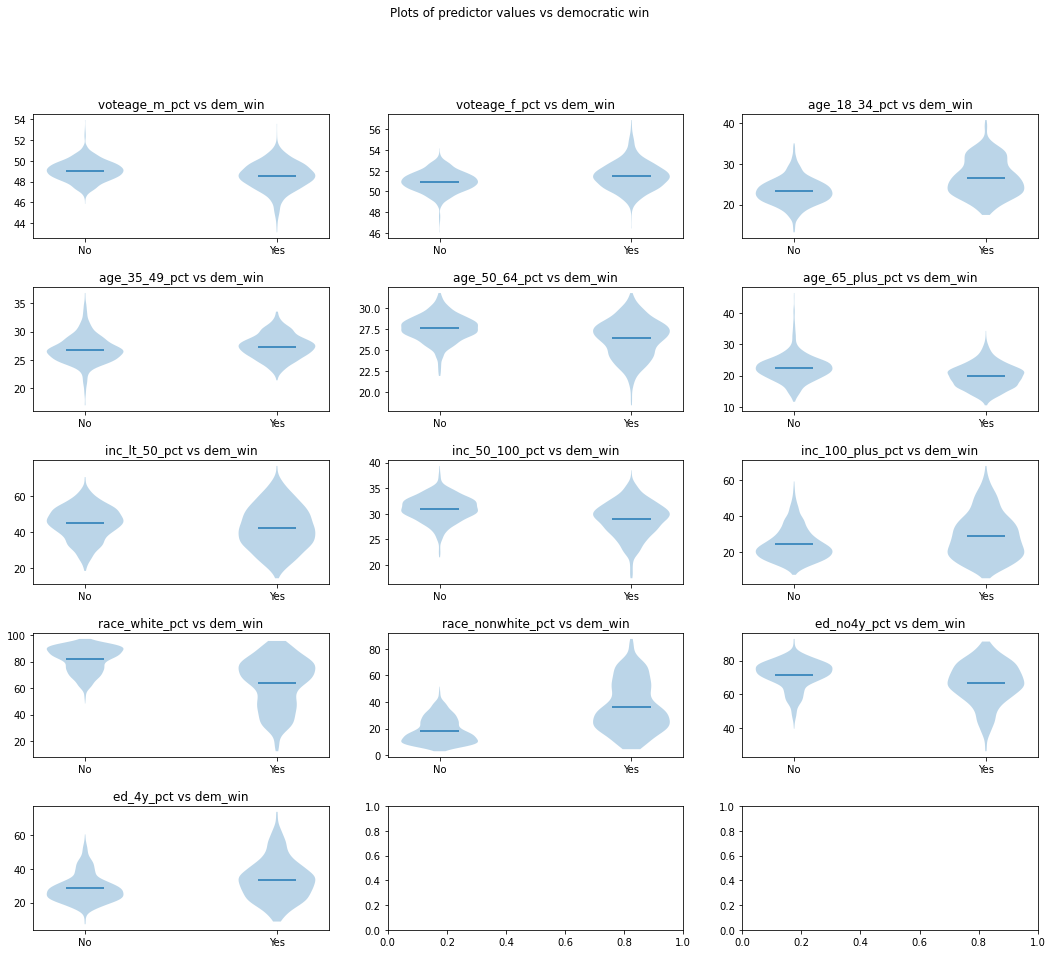

In [36]:
predsA = [x + "_pct" for x in arr_pcts]

#preds = ['voteage_m_pct', 'voteage_f_pct',
#         'race_white_pct', 'race_black_pct', 'race_asian_pct', 'race_hisp_pct']

#print(df[['voteage_m_pct', 'dem_win']][100:150])

# create a plot for given axes
# args: ax = ax graphing object, n = index of graph, p = predictor name, y = response name,
#       X = data frame with p and y
def plot_violin(ax, n, p, y, X):
    X0 = X.loc[X[y] == False]
    X1 = X.loc[X[y] == True]
    ax[n].violinplot([X0[p].values, X1[p].values], [False,True],
                     widths=0.4, showmeans=True, showextrema=False, showmedians=False);
    ax[n].set_xticks([0.0, 1.0])
    ax[n].set_xticklabels(['No', 'Yes'])
    ax[n].set_title(f'{p} vs {y}')
    return

ncol = 3
nrow = math.ceil(len(arr_pcts)/ncol)
fig, ax = plt.subplots(nrow,ncol, figsize = (18,15))
ax = ax.ravel()
for n, p in enumerate(predsA):
    plot_violin(ax, n, p, 'dem_win', df)

fig.suptitle('Plots of predictor values vs democratic win')
fig.subplots_adjust(hspace=0.4)
plt.show()


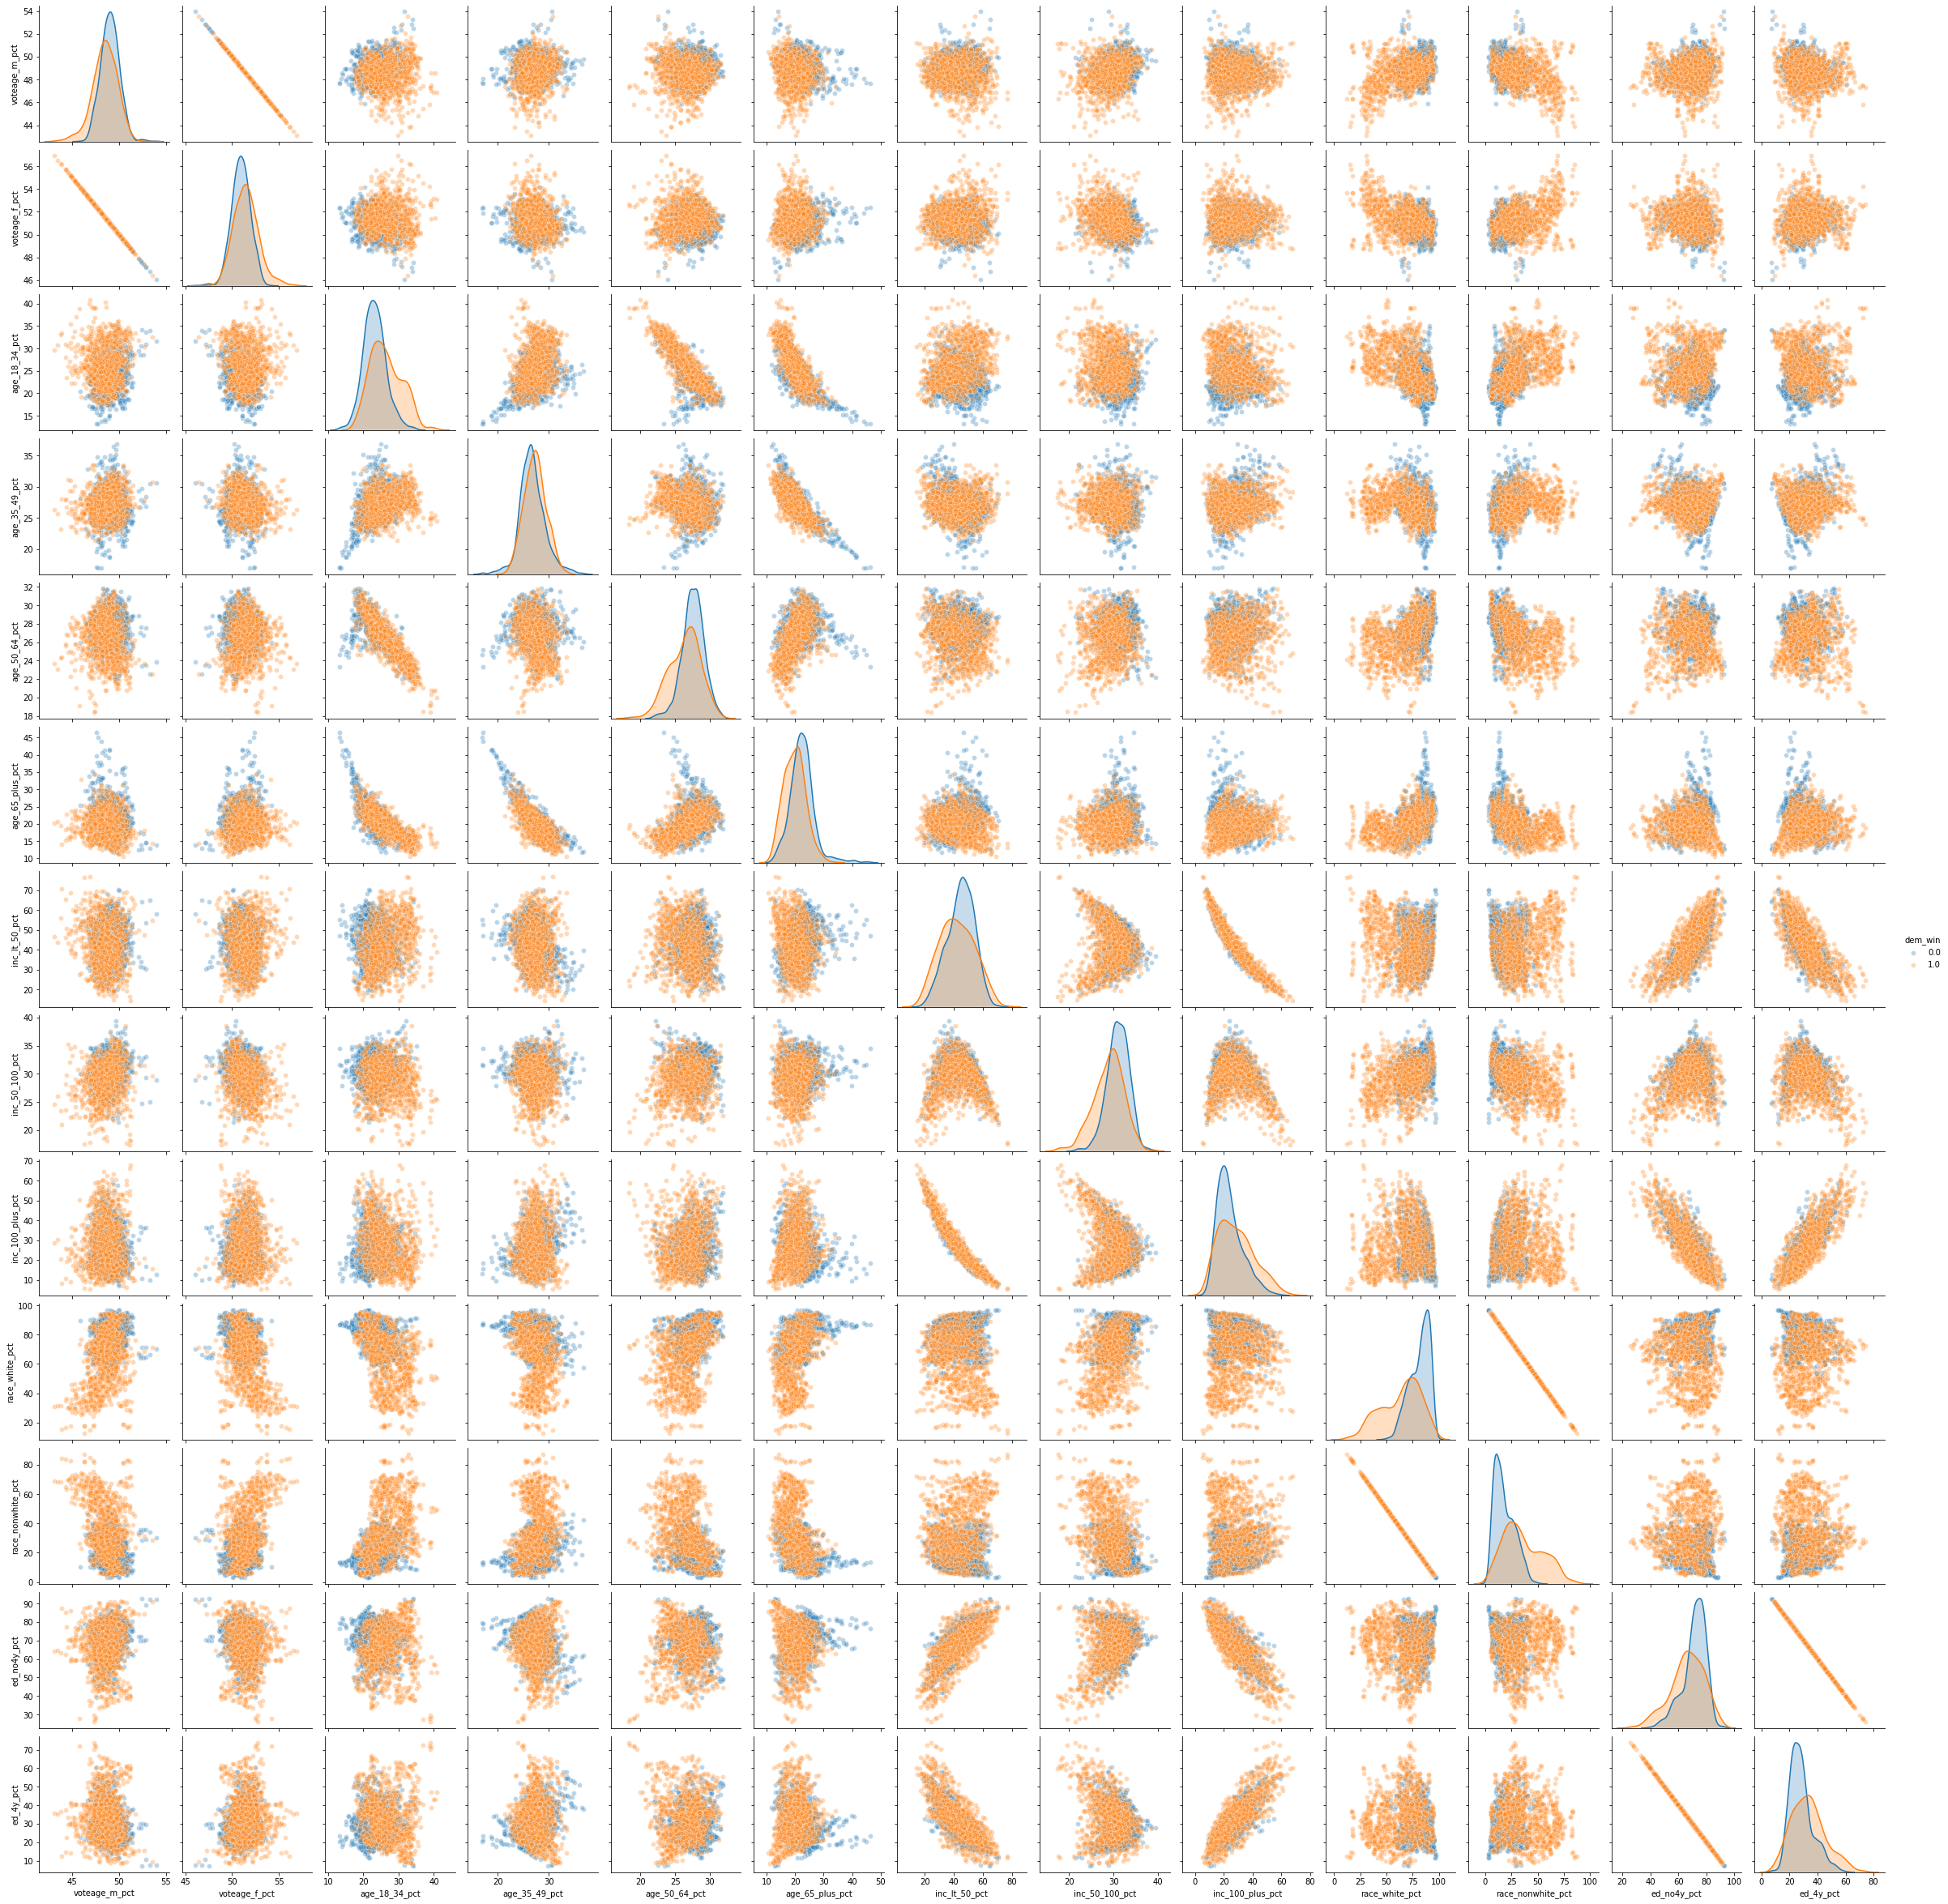

In [29]:

sns.pairplot(df, vars=predsA, hue='dem_win',
             plot_kws=dict(alpha=0.3))


### Add in polling numbers

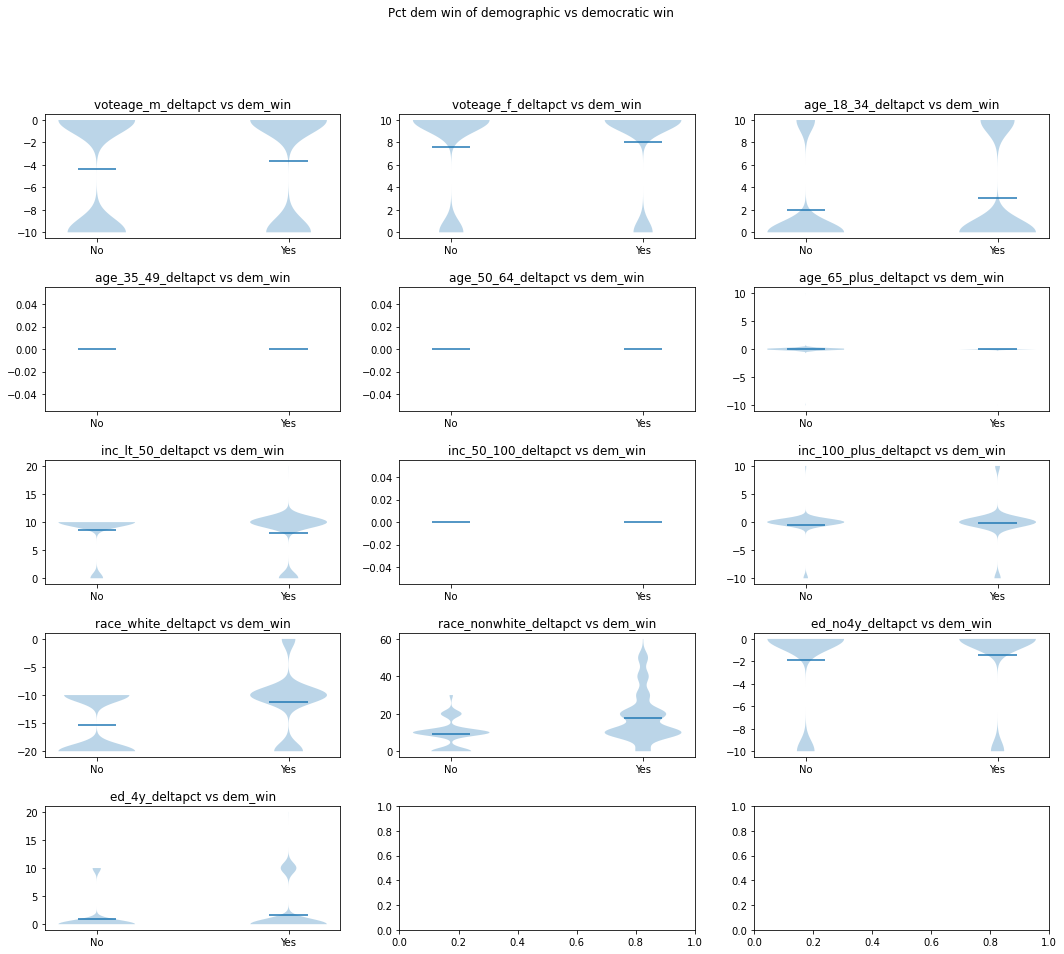

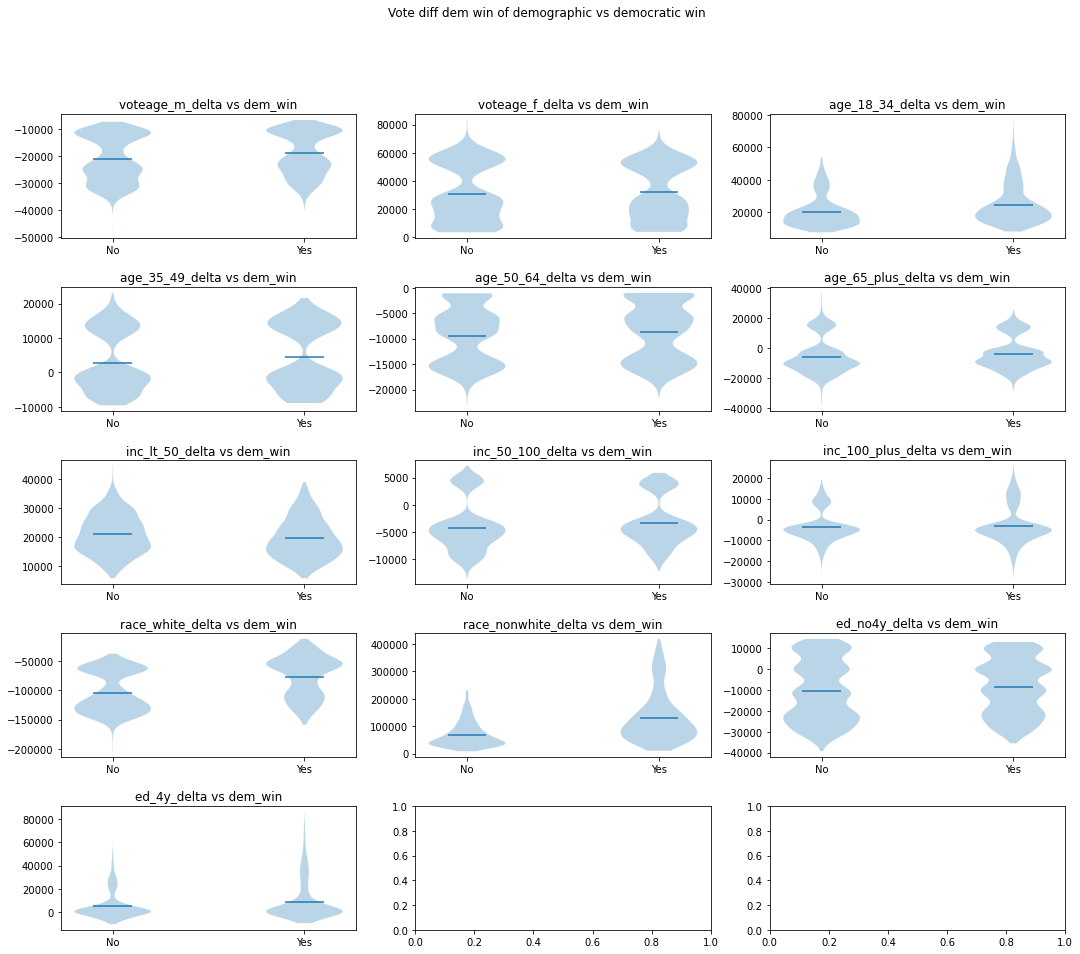

In [37]:
predsB = [x + "_deltapct" for x in arr_pcts]
predsC = [x + "_delta" for x in arr_pcts]

ncol = 3
nrow = math.ceil(len(arr_pcts)/ncol)
fig, ax = plt.subplots(nrow,ncol, figsize = (18,15))
ax = ax.ravel()
for n, p in enumerate(predsB):
    plot_violin(ax, n, p, 'dem_win', df)

fig.suptitle('Pct dem win of demographic vs democratic win')
fig.subplots_adjust(hspace=0.4)
plt.show()

fig, ax = plt.subplots(nrow,ncol, figsize = (18,15))
ax = ax.ravel()
for n, p in enumerate(predsC):
    plot_violin(ax, n, p, 'dem_win', df)

fig.suptitle('Vote diff dem win of demographic vs democratic win')
fig.subplots_adjust(hspace=0.4)
plt.show()


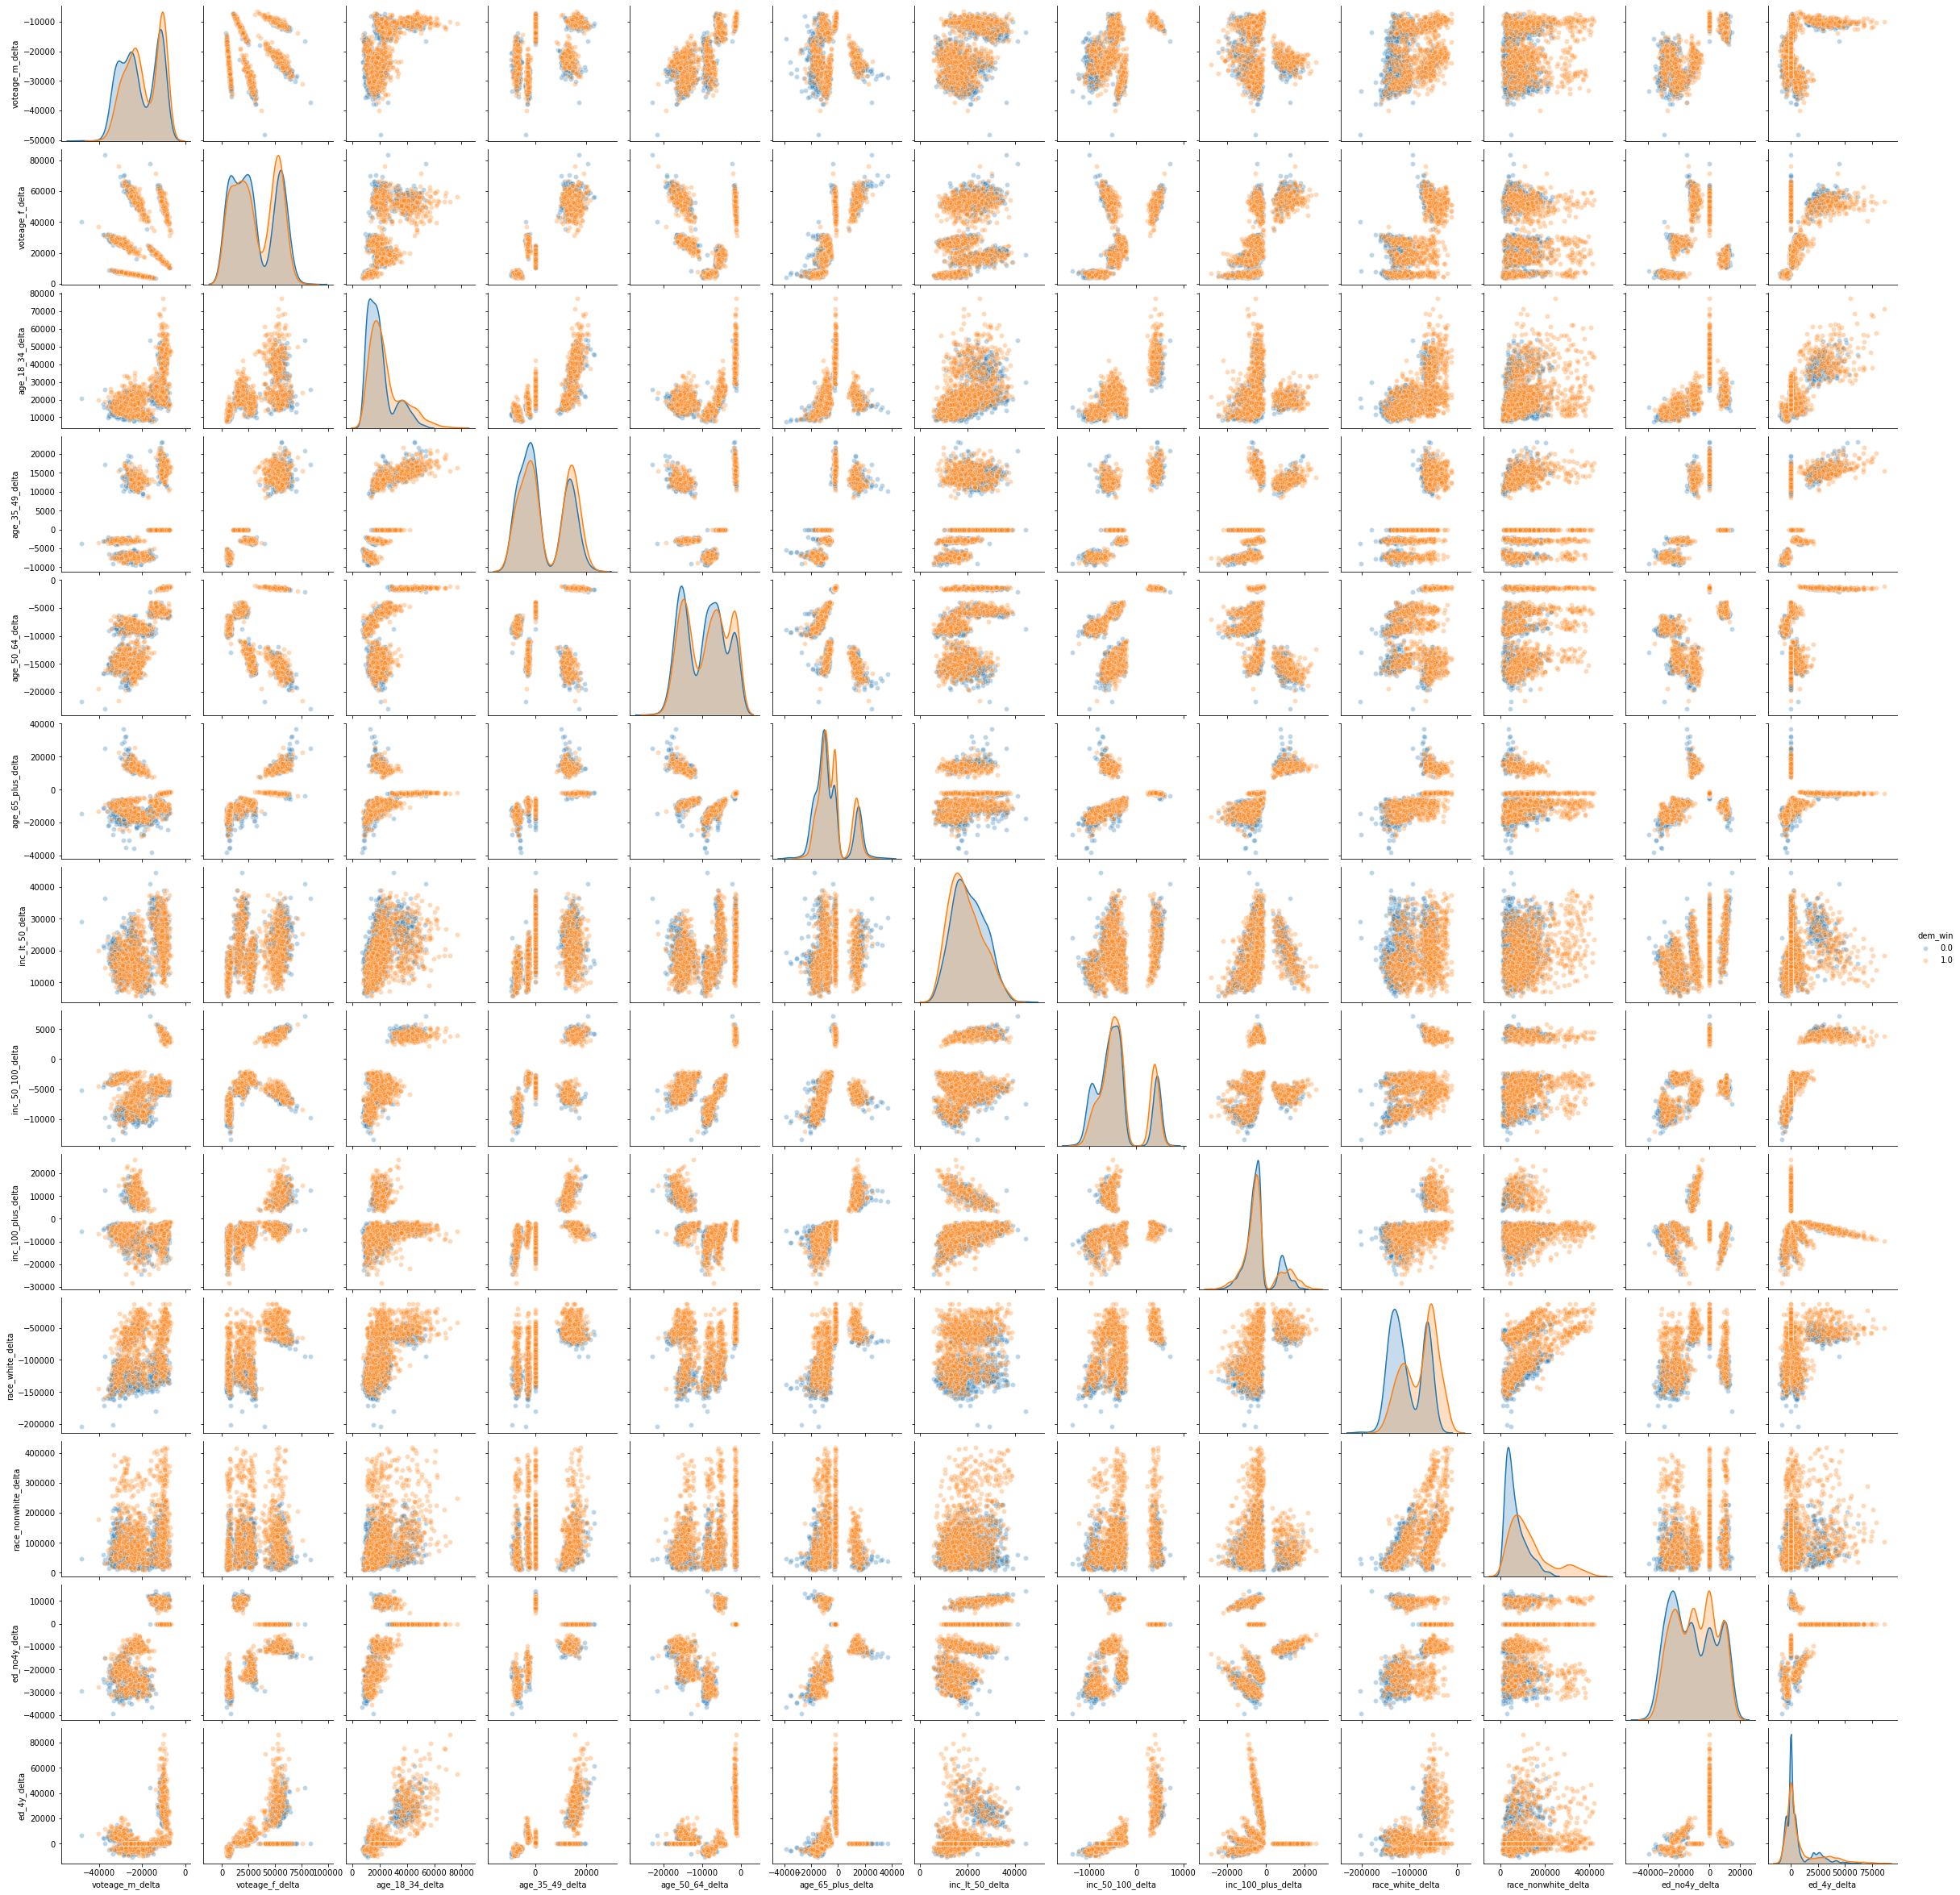

In [35]:
#sns.pairplot(df, vars=predsB, hue='dem_win',
#             plot_kws=dict(alpha=0.3))
sns.pairplot(df, vars=predsC, hue='dem_win',
             plot_kws=dict(alpha=0.3))

In [46]:
preds3 = predsA + predsB + predsC
#print(preds3)


In [47]:
notworking = """

fig, ax = plt.subplots(5,3, figsize = (18,10))
ax = ax.ravel()
for i in range(len(preds3)):
    sns.kdeplot(df[preds3[i]], df['dem_win'], ax=ax[i])
    #ax[i].set_yticks([0.0, 1.0])
    #ax[i].set_yticklabels(['Rep', 'Dem'])
    break
fig.subplots_adjust(hspace=0.4)
fig.suptitle('Plots of feature histograms of winning party')
plt.show()
"""

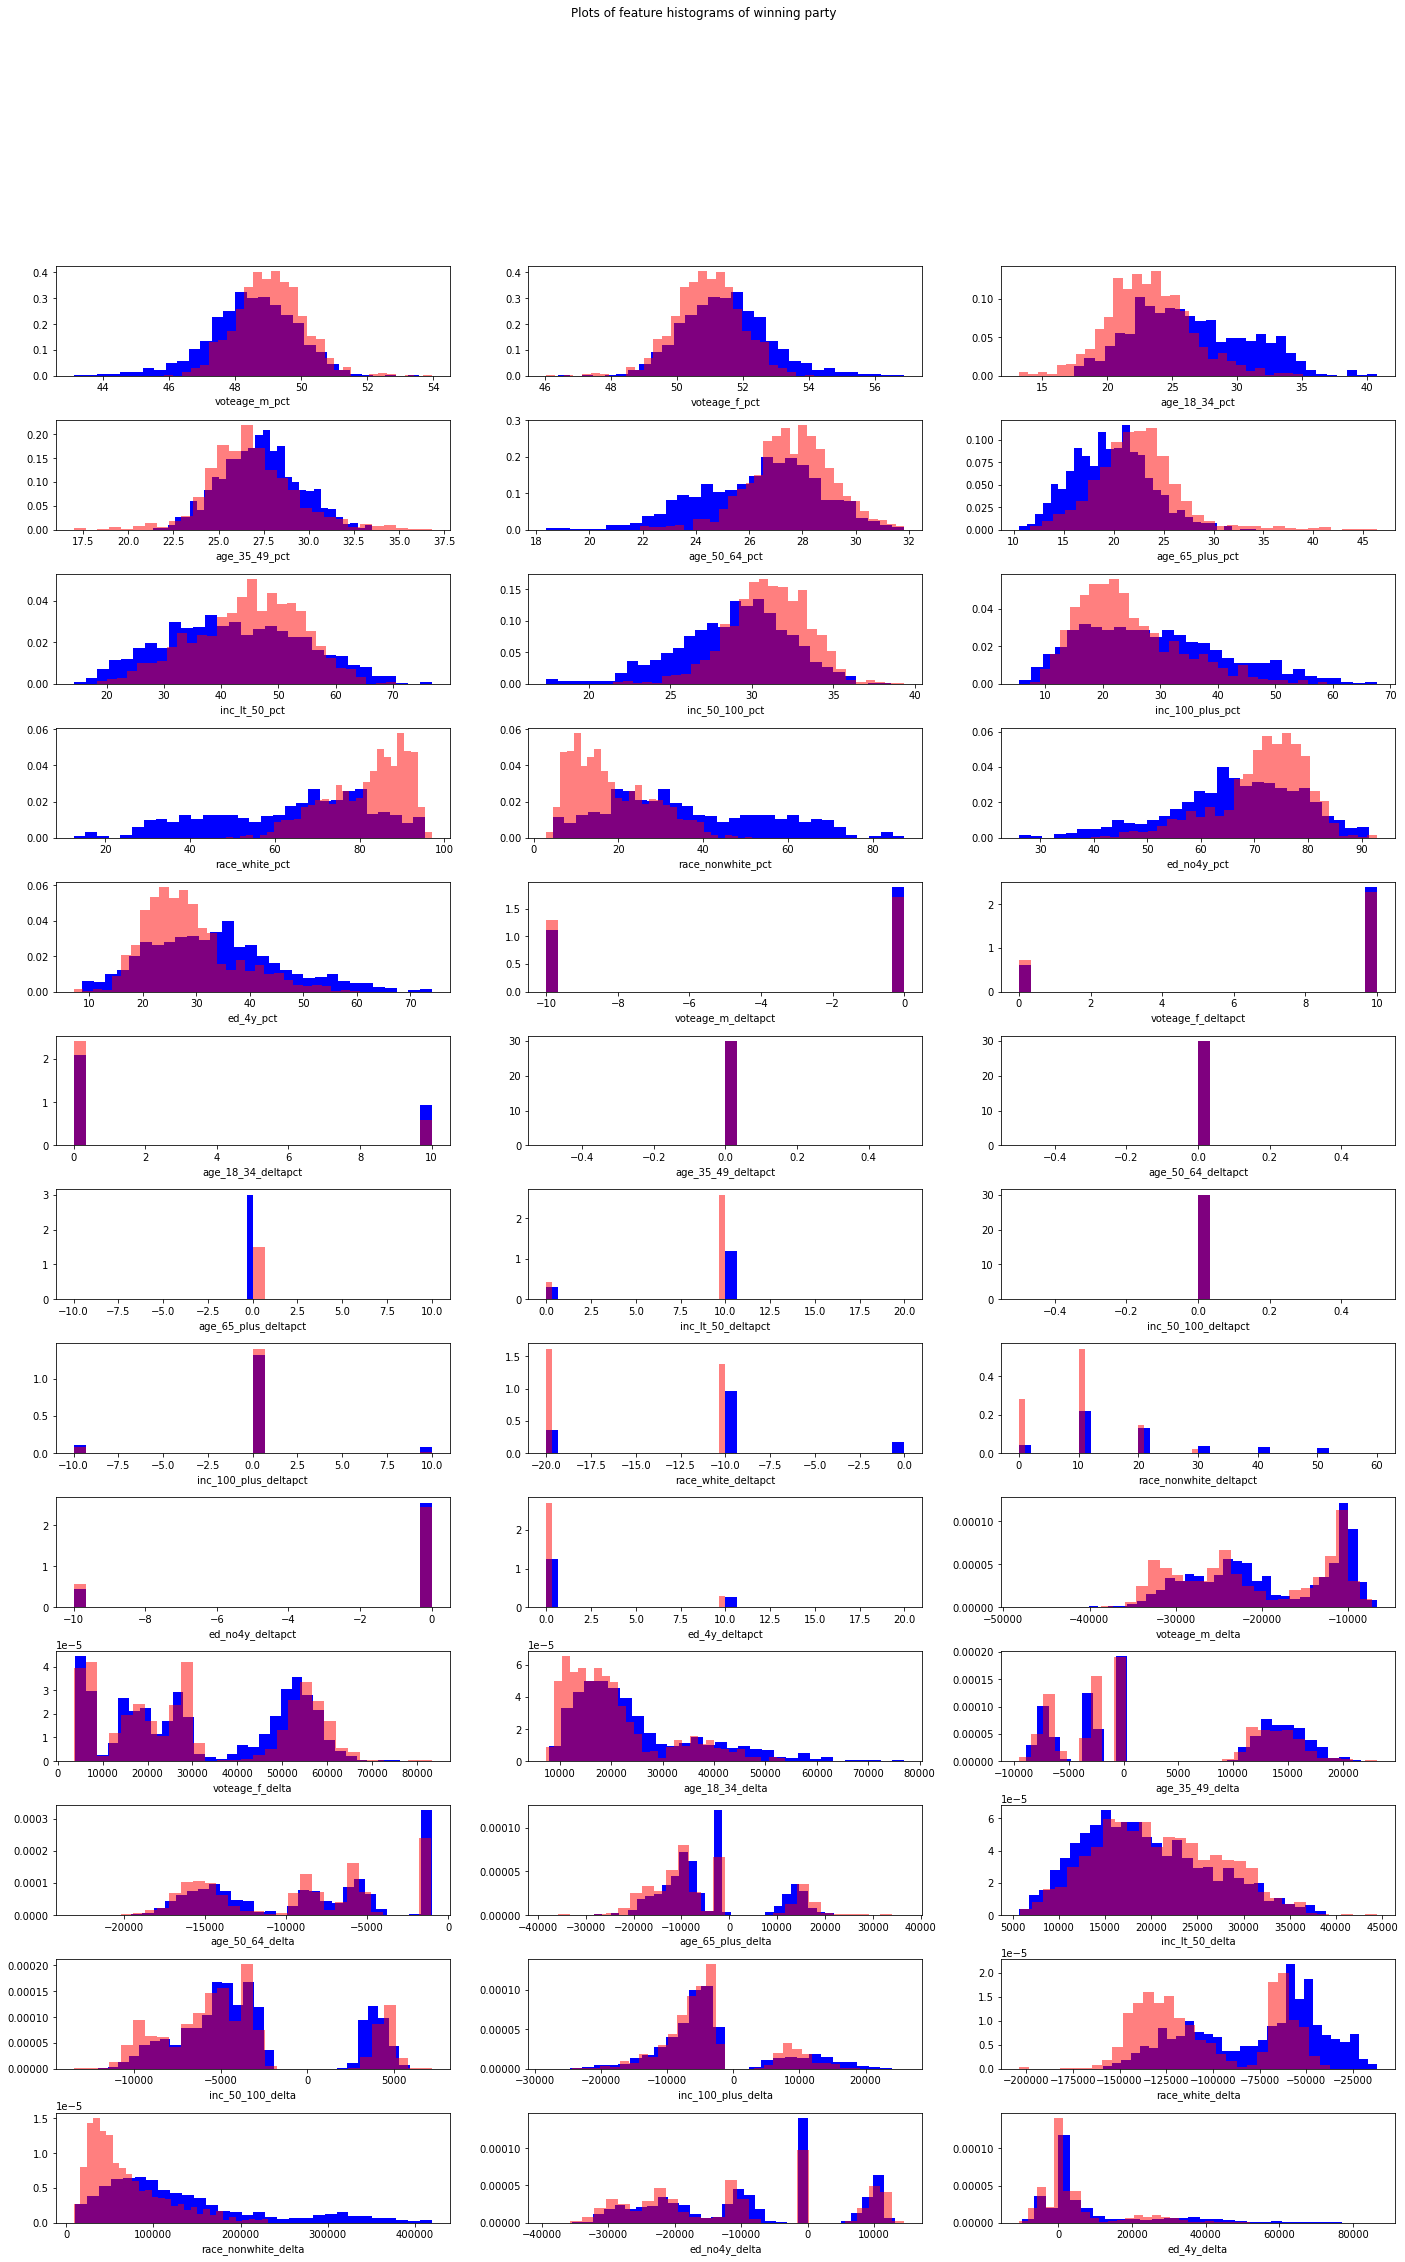

In [48]:
ncol = 3
nrow = math.ceil(len(preds3)/ncol)
fig, ax = plt.subplots(nrow,ncol, figsize = (24,36))
ax = ax.ravel()
for i in range(len(preds3)):
    ax[i].hist(df.loc[df['dem_win'] == 1][preds3[i]], 30, density=True, color='blue')
    ax[i].hist(df.loc[df['dem_win'] != 1][preds3[i]], 30, density=True, color='red', alpha=0.5)
    ax[i].set_xlabel(preds3[i])
    #break
fig.subplots_adjust(hspace=0.4)
fig.suptitle('Plots of feature histograms of winning party')
plt.show()


### By magnitude of win (vote difference)

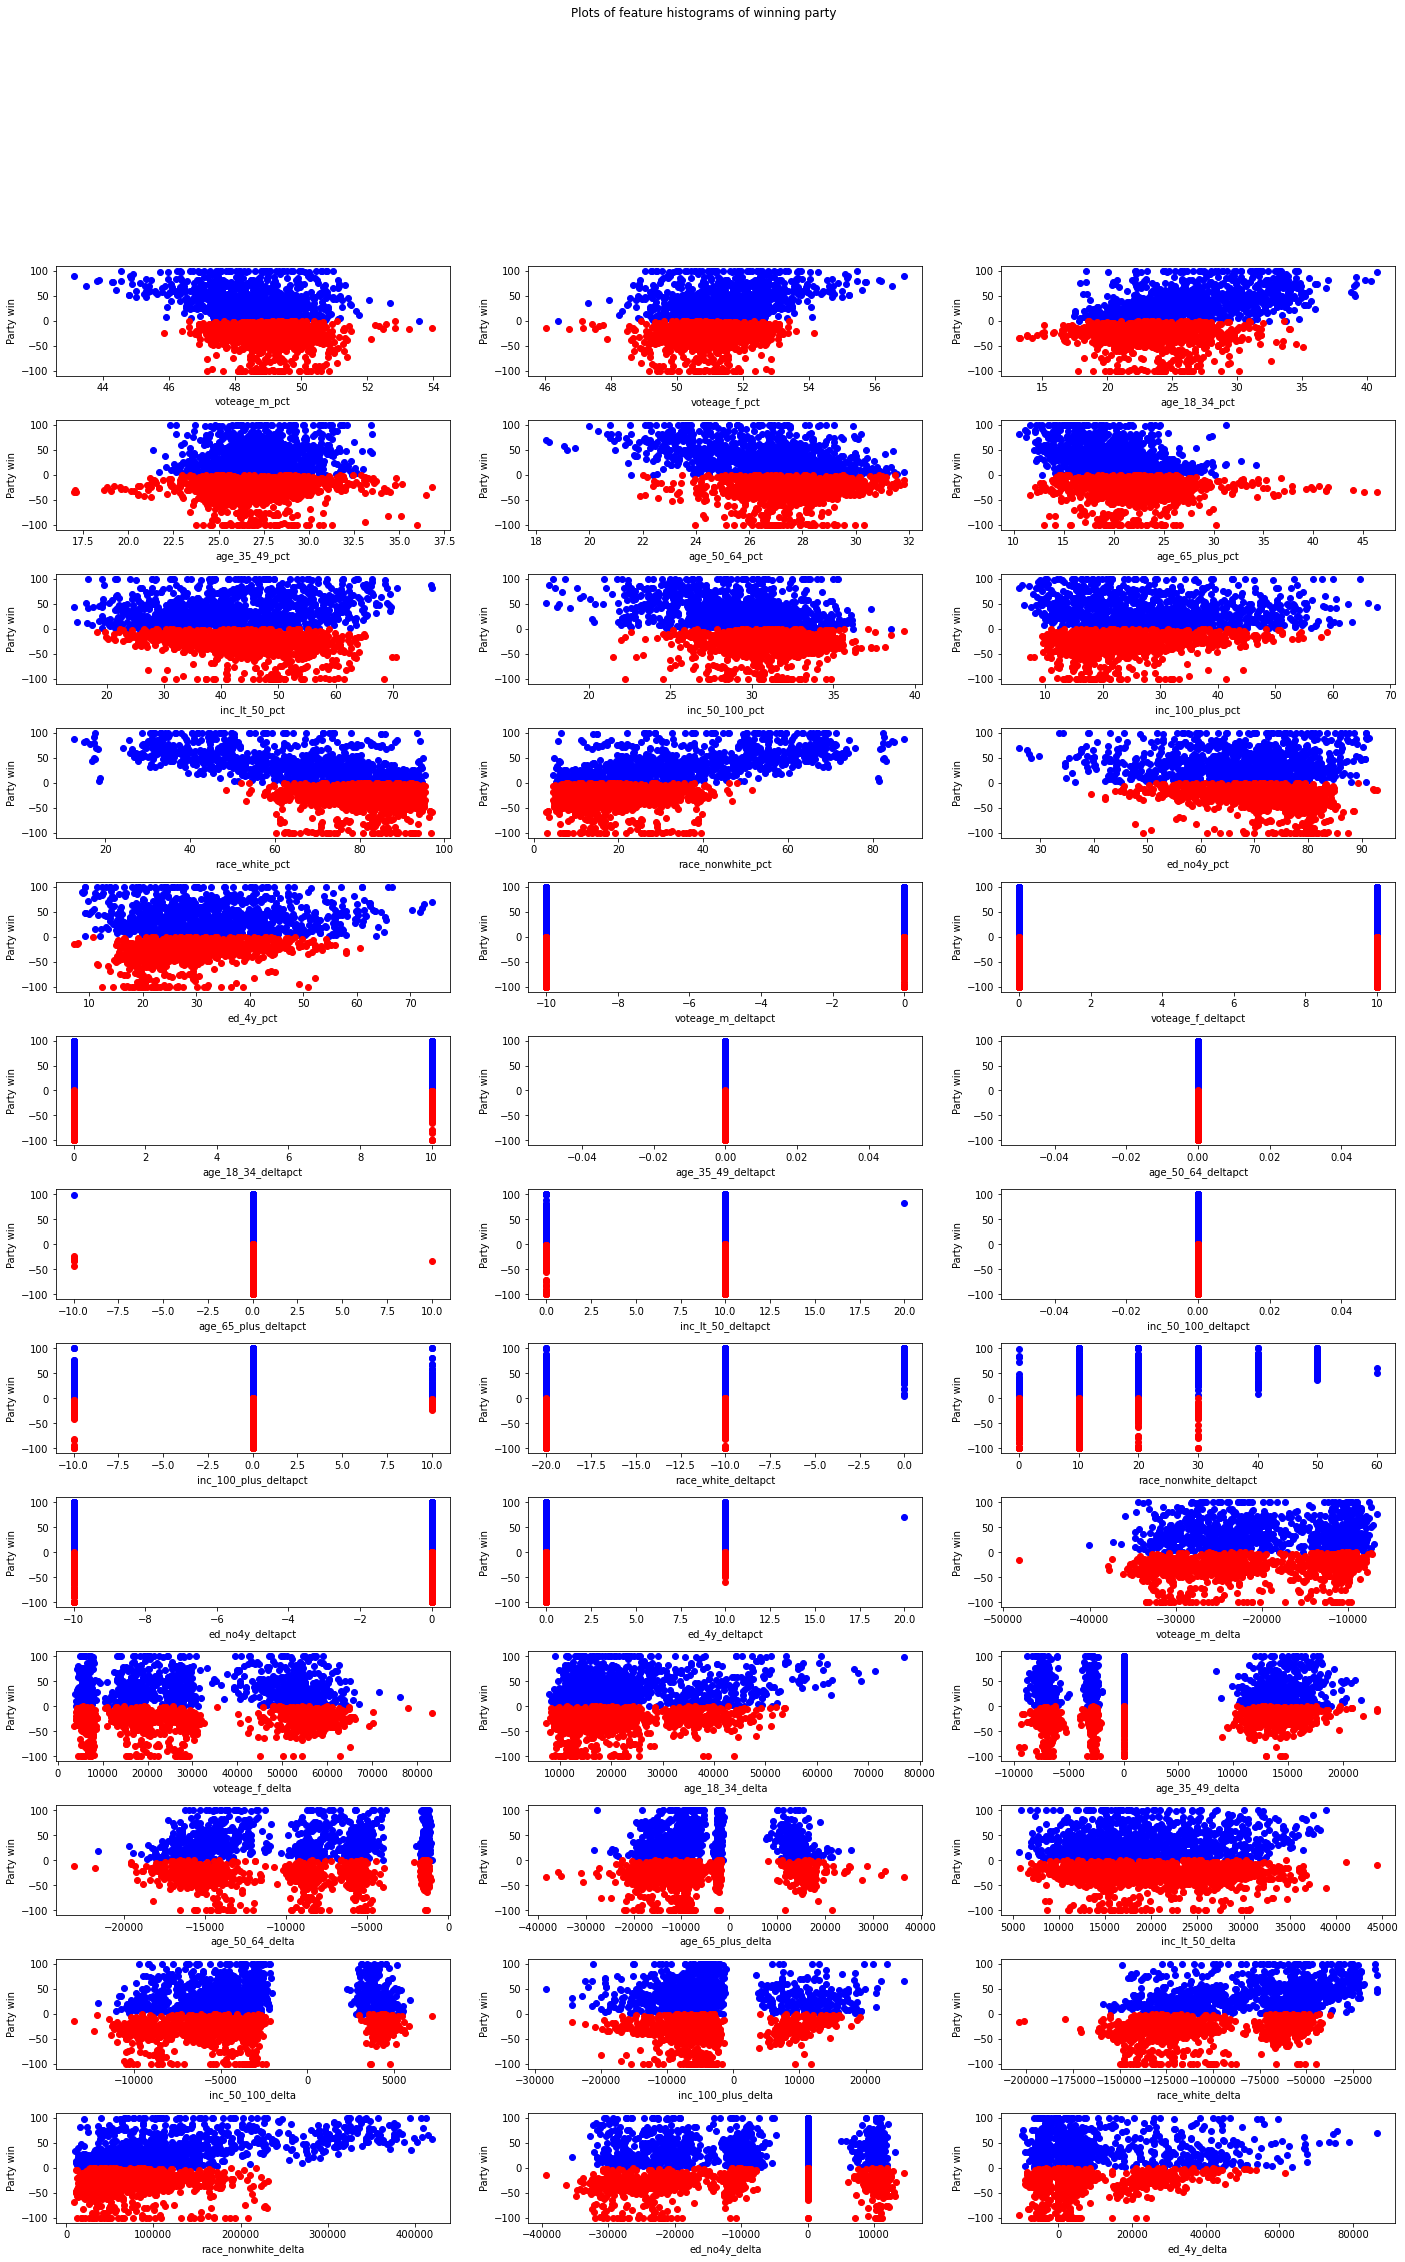

In [49]:
ncol = 3
nrow = math.ceil(len(preds3)/ncol)
fig, ax = plt.subplots(nrow,ncol, figsize = (24,36))
ax = ax.ravel()
dfD = df.loc[df['dem_win'] == 1]
dfR = df.loc[df['dem_win'] != 1]

for i in range(len(preds3)):
    ax[i].scatter(dfD[preds3[i]], dfD['demrepdiff'], color='blue')
    ax[i].scatter(dfR[preds3[i]], dfR['demrepdiff'], color='red')
    #ax[i].hist(df.loc[df['dem_win'] != 1][preds3[i]], 30, density=True, color='red', alpha=0.5)
    ax[i].set_xlabel(preds3[i])
    ax[i].set_ylabel('Party win')
    #break
fig.subplots_adjust(hspace=0.4)
fig.suptitle('Plots of feature histograms of winning party')
plt.show()


### Model

In [71]:
random_state = 12345
max_depth = 12
n_estimators = 10
random_forest = RandomForestClassifier(random_state=random_state, max_depth=max_depth,
                                       n_estimators=n_estimators)

# Fit the model on the training set
random_forest.fit(X_train.values, y_train.values)

random_forest_result = permutation_importance(random_forest, X_train, y_train, random_state=random_state)

# We make predictions on the validation set 
y_train_pred = random_forest.predict(X_train)
y_test_pred = random_forest.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
print(f"Train accuracy = {acc_train:0.4f}")
acc_test = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy = {acc_test:0.4f}")




Train accuracy = 0.9925
Test accuracy = 0.9265


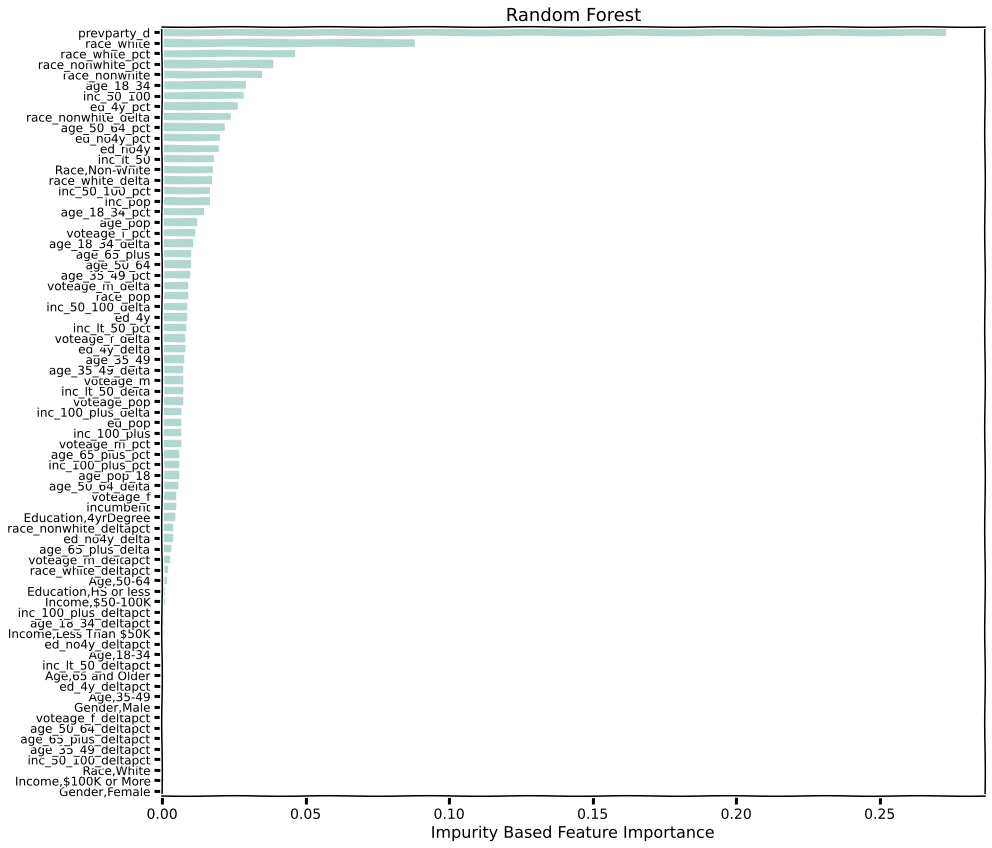

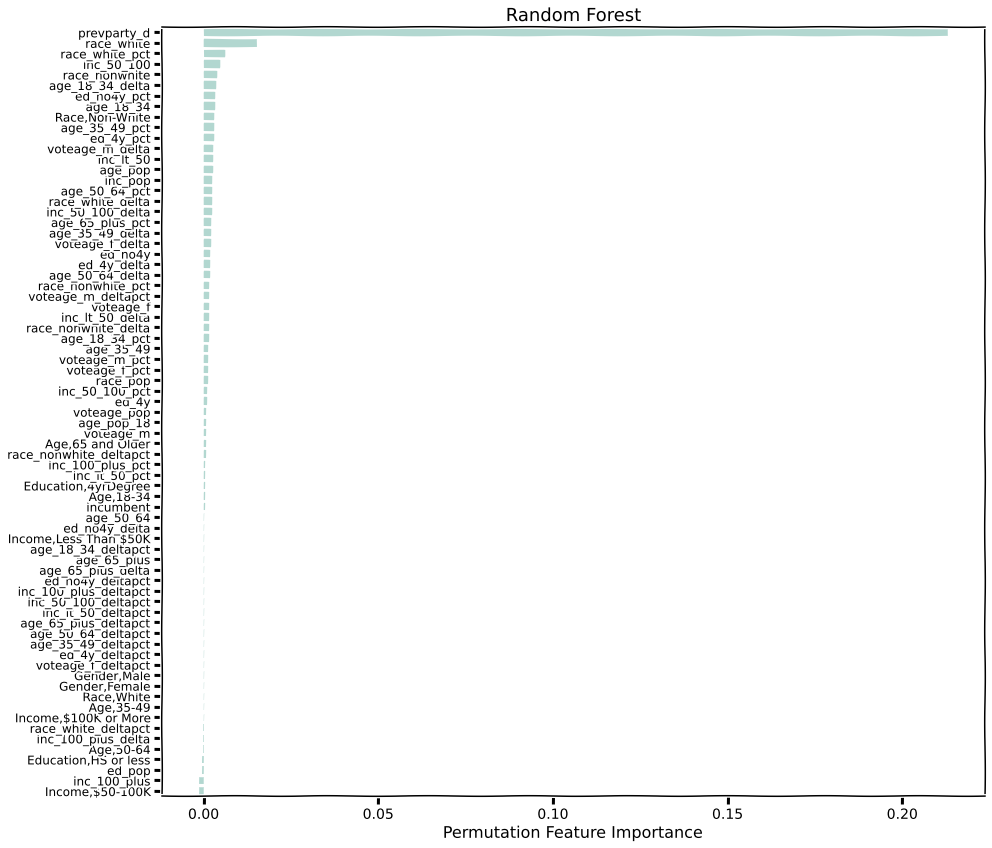

In [77]:
# From CS109A Lecture 25 helper.py (with slight modifications)

# Helper function to plot the impurity-based feature importances of the defined 
def plot_feature_importance(model1,X,y):
    
    plt.xkcd(scale=0.3,randomness=0.6)
#     maxlim = max(max(model1.feature_importances_),max(model2.feature_importances_))
    fig, (ax1) = plt.subplots(1, 1, figsize=(14, 12))

    # Plot for Random Forest
    tree_importance_sorted_idx = np.argsort(model1.feature_importances_)
    tree_indices = np.arange(0, len(model1.feature_importances_)) + 0.5

    ax1.barh(tree_indices, 
           model1.feature_importances_[tree_importance_sorted_idx], 
           height=0.7, color='#B2D7D0')
    ax1.set_yticks(tree_indices)
    ax1.set_yticklabels(X.columns[tree_importance_sorted_idx], 
                        fontsize=12)
    ax1.set_ylim((0, len(model1.feature_importances_)))
#     ax1.set_xlim((0, maxlim+0.01))
    ax1.set_xlabel("Impurity Based Feature Importance", fontsize=16)
    
    #ax1.set_ylabel("Predictors", fontsize=16)
    ax1.set_title("Random Forest", fontsize=18)
    fig.tight_layout()
    plt.show()


# Helper function to plot the feature importance for the defined model
def plot_permute_importance(result1,X,y):
#     maxlim = max(max(result1.importances_mean),max(result2.importances_mean))
    plt.xkcd(scale=0.3,randomness=0.6)
    # Plot for random forest
    fig, (ax1) = plt.subplots(1, 1, figsize=(14, 12))

    tree_importance_sorted_idx = np.argsort(result1.importances_mean)
    tree_indices = np.arange(0, len(result1.importances_mean)) +0.5

    ax1.barh(tree_indices, result1.importances_mean[tree_importance_sorted_idx], 
              height=0.7, color='#B2D7D0')
    ax1.set_yticks(tree_indices)
    ax1.set_yticklabels(X.columns[tree_importance_sorted_idx], fontsize=12)
    ax1.set_ylim((0, len(result1.importances_mean)))
    ax1.set_xlabel("Permutation Feature Importance", fontsize=16)

    #ax1.set_ylabel("Predictors", fontsize=16)
    ax1.set_title("Random Forest", fontsize=18)
    fig.tight_layout()
    plt.show()


# 
plot_feature_importance(random_forest, X_train, y_train);
plot_permute_importance(random_forest_result, X_train, y_train);


### Remove previous party column

"Previous party" is a little too good - most seats are kept by the same party. Try to model it without that predictor.

In [79]:
# what if we just used the previous party as the prediction
acc_train = accuracy_score(y_train, X_train['prevparty_d'])
print(f"Train accuracy = {acc_train:0.4f}")
acc_test = accuracy_score(y_test, X_test['prevparty_d'])
print(f"Test accuracy = {acc_test:0.4f}")


Train accuracy = 0.9091
Test accuracy = 0.9597


Without Previous Party predictor:
Train accuracy = 0.9797
Test accuracy = 0.7678


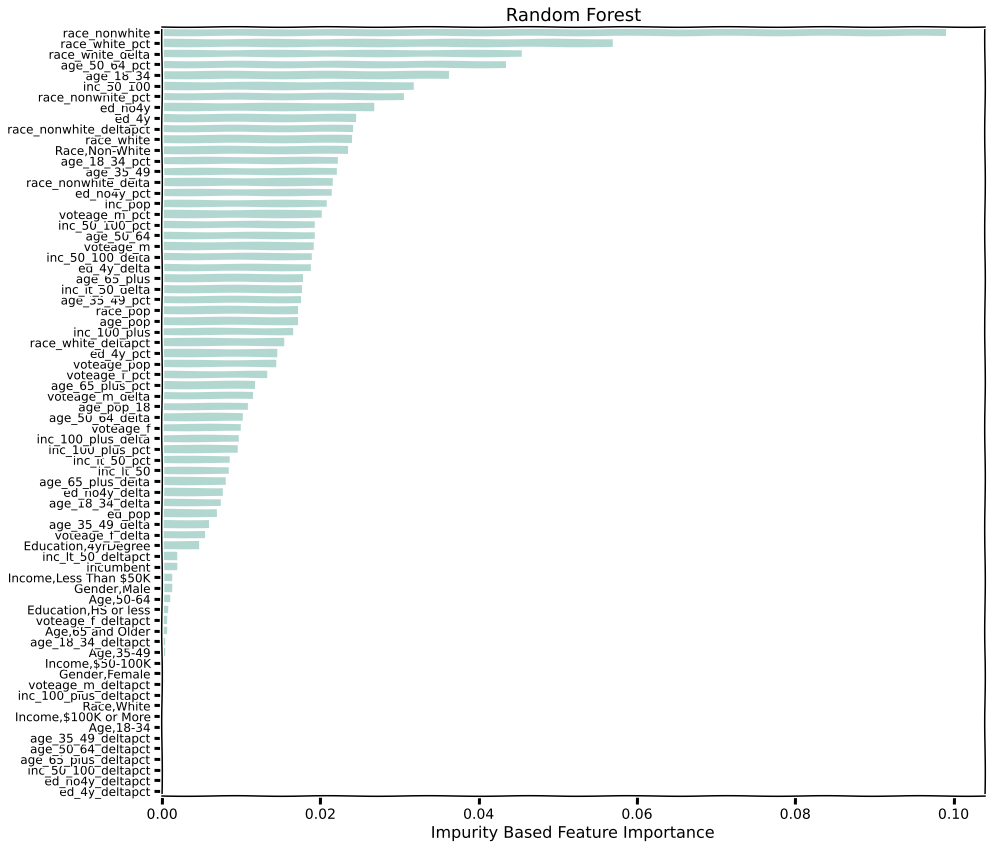

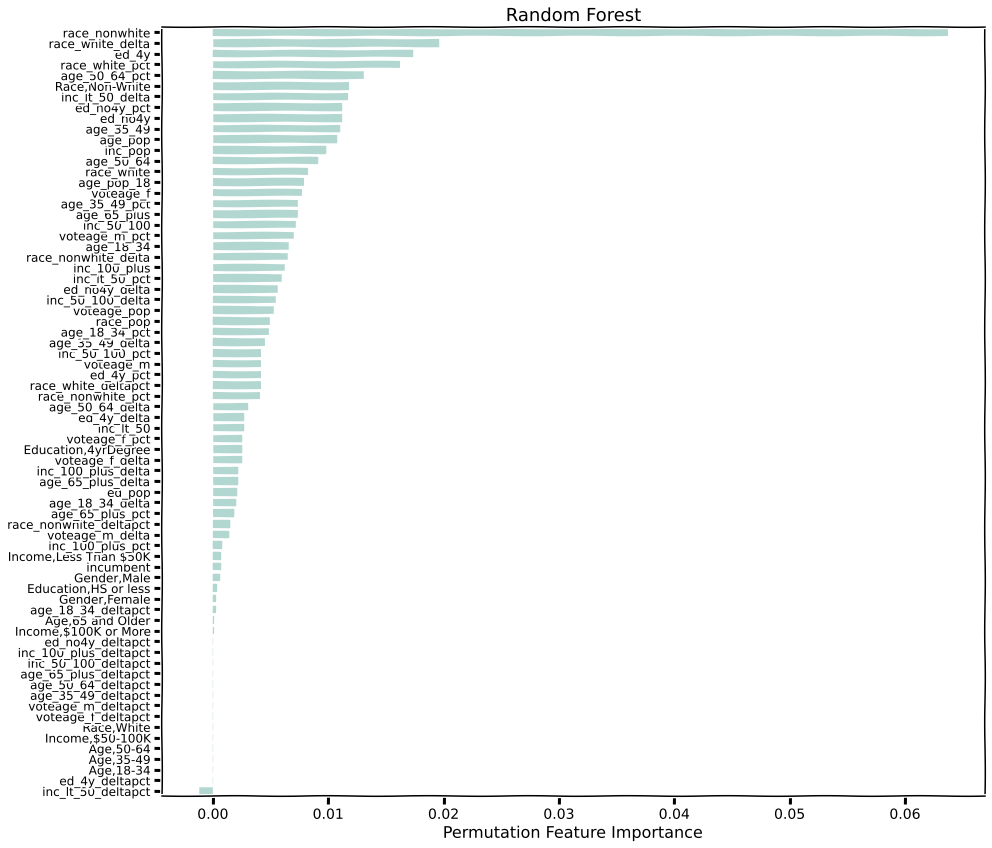

In [80]:
X_train2 = X_train.drop(columns=['prevparty_d'])
X_test2 = X_test.drop(columns=['prevparty_d'])

random_forest2 = RandomForestClassifier(random_state=random_state, max_depth=max_depth,
                                        n_estimators=n_estimators)

# Fit the model on the training set
random_forest2.fit(X_train2.values, y_train.values)

random_forest2_result = permutation_importance(random_forest2, X_train2, y_train, random_state=random_state)

# We make predictions on the validation set 
y_train2_pred = random_forest2.predict(X_train2)
y_test2_pred = random_forest2.predict(X_test2)

print("Without Previous Party predictor:")
acc_train2 = accuracy_score(y_train, y_train2_pred)
print(f"Train accuracy = {acc_train2:0.4f}")
acc_test2 = accuracy_score(y_test, y_test2_pred)
print(f"Test accuracy = {acc_test2:0.4f}")

plot_feature_importance(random_forest2, X_train2, y_train);
plot_permute_importance(random_forest2_result, X_train2, y_train);
